# Imports

In [ ]:
import numpy as np
import pandas as pd
import pylab as p
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import tensorflow as tf
from tensorflow import keras
import importlib
import models
import transformations as trans

importlib.reload(trans)
from transformations import fourier_transform_features_arr as ftf_arr
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.metrics import *
from transformations import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import importlib
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier

import transformations as trans; importlib.reload(trans)
import visualisiations as vis; importlib.reload(vis)
import models; importlib.reload(models)
import metrics as met; importlib.reload(met)

# Functions Definitions

**DISPLAY**

In [ ]:
# display matrix matrix function
def display_metrics_and_confusion_matrix(model_name, y_true, y_pred):
    """
    Displays accuracy, classification report (as a DataFrame), and a confusion matrix heatmap.
    """
    acc = accuracy_score(y_true, y_pred)

    # Convert classification report to DataFrame
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T

    # Print accuracy
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")

    # Display the classification report as a DataFrame
    display(report_df.style.background_gradient(cmap="Blues").format("{:.2f}"))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

**DATA LOADING & PREPROCESSING**

In [ ]:
# --- Load MNIST from Keras ---
"""
Loads the MNIST dataset from Keras, flattens the images from (28,28) to (784,),
normalizes pixel values to [0,1], and (optionally) reduces dimensionality using PCA.

Arguments:
    use_pca (bool): Whether to apply PCA for dimensionality reduction.
    pca_variance (float): The variance ratio to keep when applying PCA. E.g., 0.95.

Returns:
    X_train, X_test: Feature arrays (train/test).
    y_train, y_test: Label arrays (train/test).
"""


def load_and_preprocess_data(use_pca=False, pca_variance=0.95):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], 28 * 28)).astype('float32') / 255.0
    X_test = X_test.reshape((X_test.shape[0], 28 * 28)).astype('float32') / 255.0
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test, y_train, y_test

## MODELS

**BASELINE MODEL: simple neural network**
A machine learning model inspired by the human brain, consisting of layers of neurons (nodes). It processes input data through weighted connections and activation functions to learn patterns.

*Input Layer:* Receives raw data.
*Hidden Layers:* Extracts features using weighted sums and activation functions.
*Output Layer:* Produces the final prediction.

In [ ]:
def build_baseline_neural_network(input_dim, num_classes=10):
    """
    Builds a simple feed-forward neural network using Keras Sequential API.

    Arguments:
        input_dim (int): Dimensionality of input features (784 for raw MNIST, or fewer if PCA is used).
        num_classes (int): Number of output classes. Default is 10 for digits [0..9].

    Returns:
        A compiled tf.keras Sequential model.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


def train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128):
    """
    Trains the baseline neural network on the training data. Evaluates on the test set.

    Arguments:
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: The trained neural network.
        test_accuracy (float): Accuracy on the test set.
    """
    input_dim = X_train.shape[1]
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    display_metrics_and_confusion_matrix("Baseline NN", y_test, y_pred)
    return model

**KNN**
A simple, non-parametric algorithm that classifies a data point based on the majority class of its K nearest neighbors. It uses distance metrics like Euclidean distance for classification or regression

In [ ]:
def train_knn(X_train, y_train, X_test, y_test, k=3):
    """
    Trains a K-Nearest Neighbors model and evaluates on the test set.

    Arguments:
        k (int): Number of neighbors.
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    display_metrics_and_confusion_matrix("KNN", y_test, y_pred)
    return knn

**SVM**
A supervised learning algorithm that finds the best hyperplane to separate classes in a high-dimensional space. It can use kernels to handle non-linearly separable data.

In [ ]:
def train_svm(X_train, y_train, X_test, y_test, kernel='rbf'):
    """
    Trains a Support Vector Machine model with the specified kernel.

    Arguments:
        kernel (str): Kernel type ('linear', 'rbf', 'poly', etc.).
    """
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    display_metrics_and_confusion_matrix("SVM", y_test, y_pred)
    return svm

**Decision Tree**
A model that splits data into branches based on feature conditions, forming a tree-like structure. It makes decisions by following these branches down to a leaf node, which represents the final prediction

In [ ]:
def train_decision_tree(X_train, y_train, X_test, y_test, max_depth=None):
    """
    Trains a Decision Tree classifier.

    Arguments:
        max_depth (int or None): The maximum depth of the tree. If None, no maximum.
    """
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    display_metrics_and_confusion_matrix("Decision Tree", y_test, y_pred)
    return dt

**AdaBoost**
An ensemble learning method that combines multiple weak classifiers (usually decision trees) into a strong classifier by assigning higher weights to misclassified points and training iteratively.

In [ ]:
def train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50):
    """
    Trains an AdaBoost classifier with decision trees as base estimators.

    Arguments:
        n_estimators (int): Number of weak learners.
    """
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators, random_state=42)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    display_metrics_and_confusion_matrix("AdaBoost", y_test, y_pred)
    return ada

**Random Forest**
An ensemble method that builds multiple decision trees and combines their outputs (by majority vote for classification or averaging for regression) to improve accuracy and reduce overfitting.

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100):
    """
    Trains a Random Forest classifier.

    Arguments:
        n_estimators (int): Number of trees in the forest.
    """
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    display_metrics_and_confusion_matrix("Random Forest", y_test, y_pred)
    return rf

**OPTIONAL ENSEMBLE**

In [127]:

def compute_class_weights(models, X_val, y_val):
    weights = []
    for model in models:

        y_pred = model.predict(X_val)
        f1_scores = f1_score(y_val, y_pred, average=None)  # Per-class F1 scores
        weights.append({i: f1_scores[i] for i in range(len(f1_scores))})
    return weights


def train_ensemble(models, X_test, y_test):
    """
    Simple demonstration of a majority-voting ensemble.
    `models` is a list of trained (model_name, model) tuples.
    We'll do a simple majority vote on predictions.
    """
    predictions = [model.predict(X_test).reshape(-1, 1) for _, model in models]
    predictions = np.concatenate(predictions, axis=1)
    final_preds = [np.bincount(row).argmax() for row in predictions]
    display_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, final_preds)
    return np.array(final_preds)


def dynamic_weighted_ensemble(models, X_test, y_test, custom_weights=None):
    """
    Combines predictions from multiple models using dynamically assigned weights per class.

    Arguments:
        models (list): List of trained models.
        X_test (array-like): Test feature set.
        y_test (array-like): True labels.
        custom_weights (list of dicts, optional): A list where each dictionary contains class-specific weights for a model (weight for each classification option).

    Returns:
        y_final_pred: Final predictions using dynamically weighted voting.
    """
    if custom_weights is None:
        custom_weights = [{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} for _ in models]

    num_classes = len(np.unique(y_test))  # Get number of unique classes dynamically

    predictions_of_models = [m.predict(X_test) for m in models]
    # Initialize the final prediction list
    final_pred = [0] * len(X_test)

    # For each instance in the test set
    for pic in range(len(X_test)):
        classify = np.zeros(num_classes)

        # Combine predictions from all models
        for model in range(len(models)):
            class_index = predictions_of_models[model][pic]
            classify[class_index] += custom_weights[model][class_index]

        # Select the class with the highest weighted sum
        max_index = 0
        for k in range(1, len(classify)):
            if classify[k] > classify[max_index]:
                max_index = k
        final_pred[pic] = max_index

    # Evaluate model performance (assuming display_metrics_and_confusion_matrix is implemented elsewhere)
    display_metrics_and_confusion_matrix("Dynamic Weighted Ensemble", y_test, final_pred)

    return final_pred



## Run Models ##
**Load data:**

In [ ]:
# --- Load data with optional PCA ---
# Set use_pca=True to reduce dimensionality to 95% variance
X_train, X_test, y_train, y_test = load_and_preprocess_data(use_pca=False, pca_variance=0.95)

**Baseline - Neural Network:**

In [ ]:
nn_model = train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128)
# We can get predictions for evaluation
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)

**KNN:**

In [ ]:
knn_model = train_knn(X_train, y_train, X_test, y_test, k=3)
y_pred_knn = knn_model.predict(X_test)

**SVM:**


=== SVM ===
Accuracy: 0.9792


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.99,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.98,0.97,0.97,1028.00
8,0.97,0.98,0.97,974.00
9,0.97,0.96,0.97,1009.00


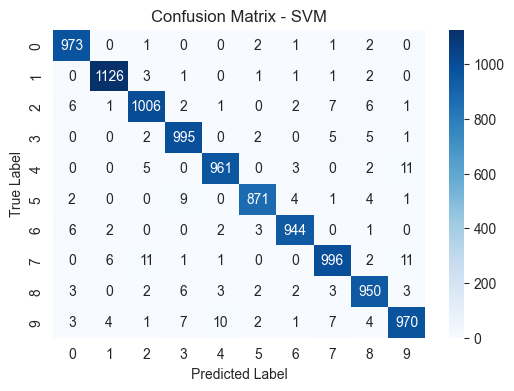

In [ ]:
svm_model = train_svm(X_train, y_train, X_test, y_test, kernel='rbf')
y_pred_svm = svm_model.predict(X_test)

**Decision Tree:**


=== Decision Tree ===
Accuracy: 0.8663


,precision,recall,f1-score,support
0,0.91,0.94,0.92,980.00
1,0.95,0.96,0.95,1135.00
2,0.85,0.84,0.84,1032.00
3,0.82,0.84,0.83,1010.00
4,0.86,0.85,0.86,982.00
5,0.84,0.80,0.82,892.00
6,0.91,0.87,0.89,958.00
7,0.90,0.88,0.89,1028.00
8,0.80,0.81,0.80,974.00
9,0.81,0.86,0.83,1009.00


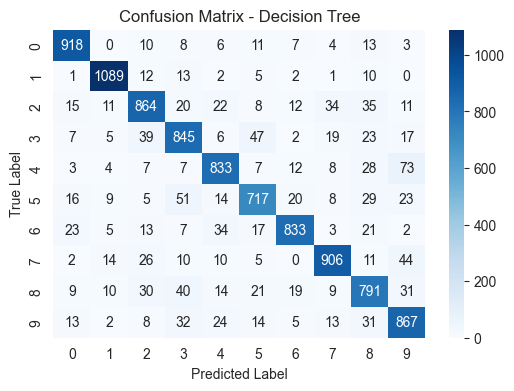

In [ ]:
dt_model = train_decision_tree(X_train, y_train, X_test, y_test, max_depth=10)
y_pred_dt = dt_model.predict(X_test)

**AdaBoost**


=== AdaBoost ===
Accuracy: 0.5756


,precision,recall,f1-score,support
0,0.90,0.60,0.72,980.00
1,0.90,0.32,0.48,1135.00
2,0.56,0.67,0.61,1032.00
3,0.44,0.65,0.53,1010.00
4,0.50,0.51,0.50,982.00
5,0.46,0.50,0.48,892.00
6,0.82,0.70,0.76,958.00
7,0.69,0.60,0.64,1028.00
8,0.52,0.75,0.62,974.00
9,0.43,0.47,0.45,1009.00


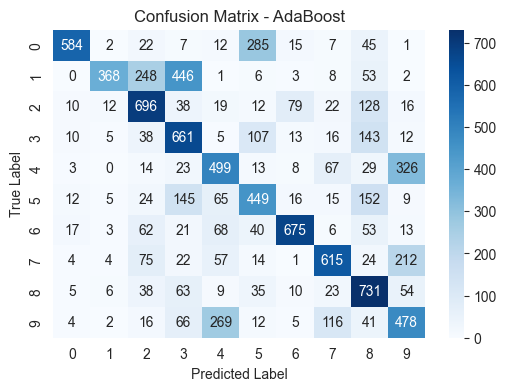

In [ ]:
ada_model = train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50)
y_pred_ada = ada_model.predict(X_test)

**Random Forest:**


=== Random Forest ===
Accuracy: 0.9704


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.99,0.99,0.99,1135.00
2,0.96,0.97,0.97,1032.00
3,0.96,0.96,0.96,1010.00
4,0.97,0.97,0.97,982.00
5,0.98,0.96,0.97,892.00
6,0.98,0.98,0.98,958.00
7,0.97,0.96,0.97,1028.00
8,0.96,0.95,0.96,974.00
9,0.96,0.95,0.96,1009.00


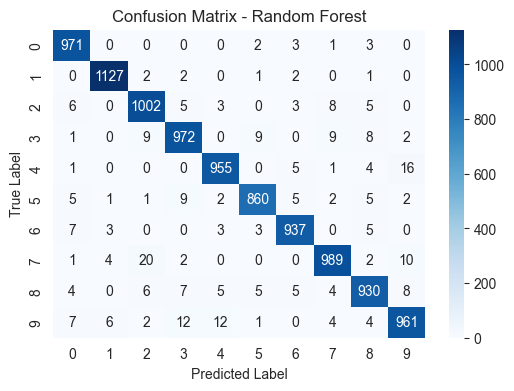

In [ ]:
rf_model = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100)
y_pred_rf = rf_model.predict(X_test)

**Ensemble (Majority Voting):**
 Here we combine the trained models above and determine the final classification by the Majority Voting of the models


=== Ensemble Majority Voting ===
Accuracy: 0.9785


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.98,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.97,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.96,0.97,1009.00


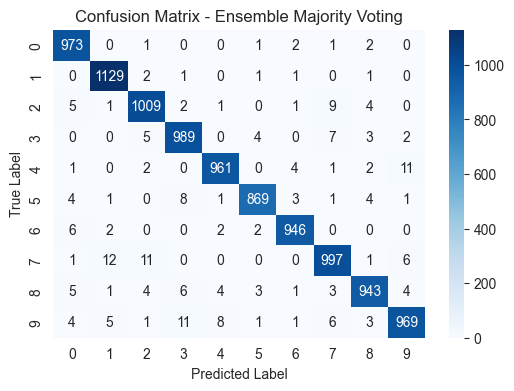

In [ ]:
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    ("RF", rf_model)
]

ensemble_preds_KNN_SVM_RF = train_ensemble(models_list, X_test, y_test)



=== Ensemble Majority Voting ===
Accuracy: 0.9791


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.95,0.97,1009.00


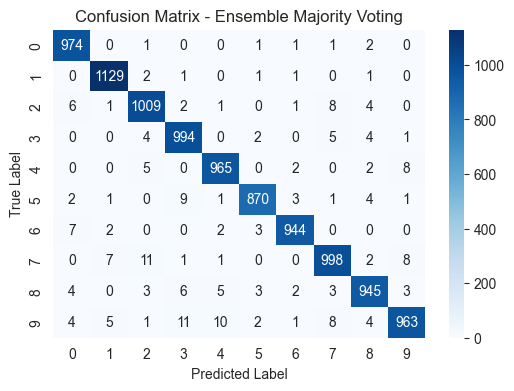

In [ ]:
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    ("SVM", svm_model),
    ("RF", rf_model)
]
ensemble_preds_KNN_SVM_SVM_RF = train_ensemble(models_list, X_test, y_test)

**Weighted Ensemble:**
Here we combine the trained models above and each model get a wight for each classification


**compute the wights** - compute the wights of the classes by a Validation Set (Not Test!)



=== Dynamic Weighted Ensemble ===
Accuracy: 0.9786


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.98,0.97,0.98,892.00
6,0.98,0.99,0.98,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.97,0.96,0.97,1009.00


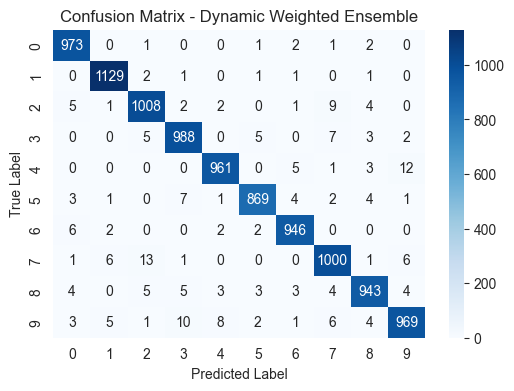

In [128]:
models_list = [svm_model, knn_model, rf_model]
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class_weights = compute_class_weights(models_list, X_val, y_val)

y_dynamic_weighted_ensemble = dynamic_weighted_ensemble(models_list, X_test, y_test, custom_weights=class_weights)


assign the weights manually:


=== Dynamic Weighted Ensemble ===
Accuracy: 0.9798


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.98,0.98,1032.00
3,0.98,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.97,0.97,0.97,1009.00


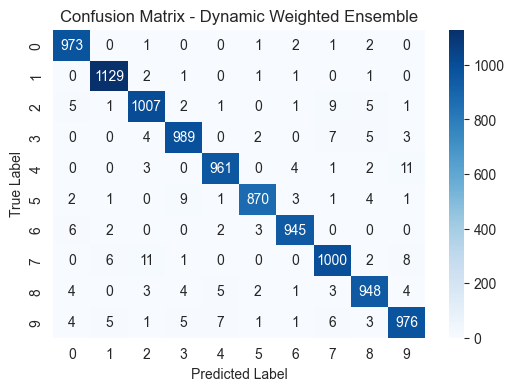

In [ ]:
  # List of trained models
weights = [
    {0: 0.4, 1: 0.4, 2: 0.4, 3: 0.5, 4: 0.4, 5: 0.6, 6: 0.45, 7: 0.45, 8: 0.51, 9: 0.6},  # Weights for model 1
    {0: 0.3, 1: 0.1, 2: 0.45, 3: 0.4, 4: 0.3, 5: 0.1, 6: 0.45, 7: 0.35, 8: 0.3, 9: 0.5},  # Weights for model 2
    {0: 0.3, 1: 0.5, 2: 0.1, 3: 0.1, 4: 0.3, 5: 0.4, 6: 0.1, 7: 0.4, 8: 0.3, 9: 0.4}  # Weights for model 3
]

y_dynamic_weighted_ensemble2 = dynamic_weighted_ensemble(models_list, X_test, y_test, custom_weights=weights)


## Predict With Transformations
in this section we will try to pre proces MNIST data with some transfornation and check how it will effect the predictions of the models

**Fourier transformation:**
A mathematical technique that converts a function or signal from the time domain to the frequency domain. It decomposes a signal into a sum of sinusoidal components (sines and cosines), making it useful for analyzing frequency content.

*Usefulness:* Converts images to the frequency domain, allowing the classifier to focus on fundamental shape structures rather than pixel values.

*Example:* A "0" and an "O" have different pixel intensity distributions, but their frequency domain representations can highlight key differences.





In [ ]:
X_train_non_flat, X_test_non_flat, Y_train_non_flat, Y_test_non_flat = models.load_preprocess_mnist_data(
    scale_features=False, flatten_image=False)
f_X_test = ftf_arr(X_test_non_flat)
f_X_train = ftf_arr(X_train_non_flat)
f_X_test = [p.flat for p in f_X_test]
f_X_train = [p.flat for p in f_X_train]

**KNN - Fourier:**


=== KNN ===
Accuracy: 0.9328


,precision,recall,f1-score,support
0,0.97,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.94,0.93,0.94,1032.00
3,0.93,0.95,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.93,0.93,0.93,892.00
6,0.84,0.86,0.85,958.00
7,0.92,0.94,0.93,1028.00
8,0.99,0.91,0.95,974.00
9,0.86,0.86,0.86,1009.00


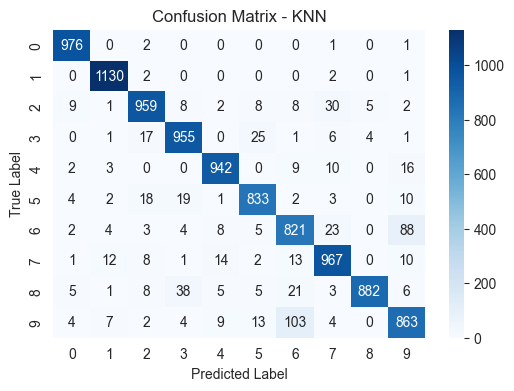

In [105]:
knn_model_fourier = train_knn(f_X_train, Y_train_non_flat, f_X_test, Y_test_non_flat, k=3)

**SVM - Fourier:**


=== SVM ===
Accuracy: 0.9301


,precision,recall,f1-score,support
0,0.98,0.98,0.98,980.00
1,0.98,0.99,0.99,1135.00
2,0.89,0.93,0.91,1032.00
3,0.96,0.92,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.92,0.92,0.92,892.00
6,0.86,0.82,0.84,958.00
7,0.95,0.93,0.94,1028.00
8,0.95,0.96,0.95,974.00
9,0.85,0.88,0.86,1009.00


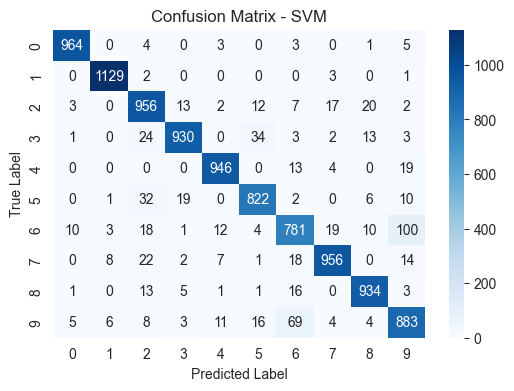

In [115]:
svm_model_fourier = train_svm(f_X_train, Y_train_non_flat, f_X_test, Y_test_non_flat)

**Random Forest - Fourier:**



=== Random Forest ===
Accuracy: 0.8777


,precision,recall,f1-score,support
0,0.94,0.97,0.96,980.00
1,0.97,0.99,0.98,1135.00
2,0.82,0.85,0.83,1032.00
3,0.84,0.87,0.85,1010.00
4,0.88,0.95,0.91,982.00
5,0.87,0.86,0.86,892.00
6,0.80,0.73,0.76,958.00
7,0.92,0.88,0.90,1028.00
8,0.90,0.85,0.88,974.00
9,0.82,0.82,0.82,1009.00


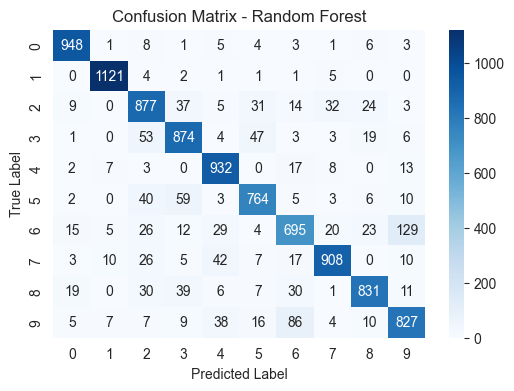

In [129]:
rf_model_fourier = train_random_forest(f_X_train, Y_train_non_flat, f_X_test, Y_test_non_flat)

**Fourier combined with regular data:**

In [ ]:
combine_test = []
for i in range(0, len(X_test)):
    combine_test.append(np.append(f_X_test[i], X_test[i]))
combine_train = []
for i in range(0, len(X_train)):
    combine_train.append(np.append(f_X_train[i], X_train[i]))

**KNN - Fourier combined with regular data**


=== KNN ===
Accuracy: 0.9328


,precision,recall,f1-score,support
0,0.97,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.94,0.93,0.94,1032.00
3,0.93,0.95,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.93,0.93,0.93,892.00
6,0.84,0.86,0.85,958.00
7,0.92,0.94,0.93,1028.00
8,0.99,0.91,0.95,974.00
9,0.86,0.86,0.86,1009.00


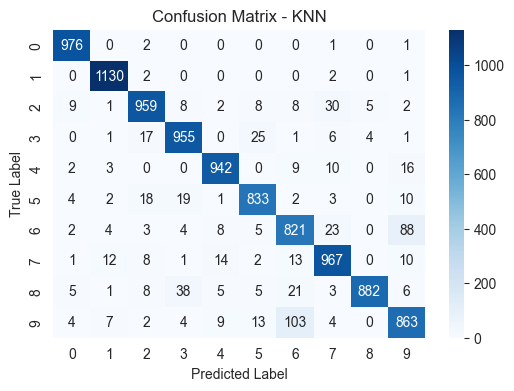

In [106]:
knn_model_fourier = train_knn(combine_train, Y_train_non_flat, combine_test, Y_test_non_flat, k=3)


**Zernike Moment**
 Feature extraction technique based on orthogonal Zernike polynomials, used to capture rotation-invariant shape characteristics of an image, often applied in character recognition.

*Usefulness:* Extracts rotation-invariant features, making classification robust to small rotations.

*Example:* A slightly rotated "6" and an upright "6" will have similar Zernike features, helping the model recognize them as the same digit.


In [107]:
train_features_zernike = preprocess_with_zernike(X_train, max_order=5)
test_features_zernike = preprocess_with_zernike(X_test, max_order=5)

**KNN - Zernike:**


=== KNN ===
Accuracy: 0.5407


,precision,recall,f1-score,support
0,0.60,0.79,0.68,980.00
1,0.70,0.87,0.78,1135.00
2,0.31,0.37,0.34,1032.00
3,0.43,0.49,0.46,1010.00
4,0.61,0.64,0.62,982.00
5,0.35,0.25,0.29,892.00
6,0.48,0.38,0.43,958.00
7,0.68,0.58,0.63,1028.00
8,0.55,0.44,0.49,974.00
9,0.63,0.54,0.58,1009.00


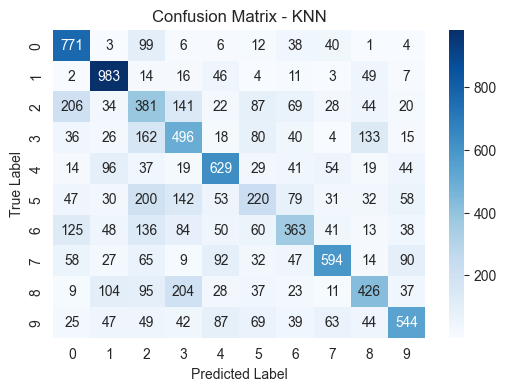

In [108]:

# Train KNN on the processed features
knn_model_zernike = train_knn(train_features_zernike, y_train, test_features_zernike, y_test, k=3)
# Predict using the trained model
y_pred_knn_zernike = knn_model_zernike.predict(test_features_zernike)

**Random Forest - Zernike:**


=== Random Forest ===
Accuracy: 0.5969


,precision,recall,f1-score,support
0,0.71,0.77,0.74,980.00
1,0.79,0.86,0.82,1135.00
2,0.44,0.34,0.39,1032.00
3,0.49,0.58,0.53,1010.00
4,0.72,0.67,0.69,982.00
5,0.43,0.34,0.38,892.00
6,0.48,0.51,0.49,958.00
7,0.66,0.67,0.66,1028.00
8,0.54,0.56,0.55,974.00
9,0.60,0.61,0.60,1009.00


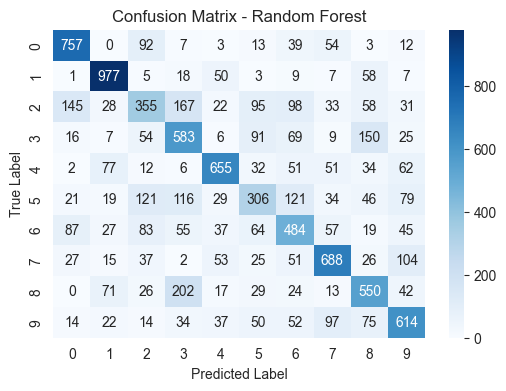

In [109]:
# Train random forest on the processed features
rf_model_zernike = train_random_forest(train_features_zernike, y_train, test_features_zernike, y_test)

# Predict using the trained model
y_pred_rf_zernike = rf_model_zernike.predict(test_features_zernike)

**SVM - Zernike:**


=== SVM ===
Accuracy: 0.5981


,precision,recall,f1-score,support
0,0.73,0.78,0.76,980.00
1,0.73,0.85,0.79,1135.00
2,0.45,0.34,0.39,1032.00
3,0.48,0.64,0.55,1010.00
4,0.71,0.65,0.68,982.00
5,0.49,0.32,0.39,892.00
6,0.51,0.45,0.47,958.00
7,0.67,0.72,0.70,1028.00
8,0.55,0.54,0.55,974.00
9,0.55,0.61,0.58,1009.00


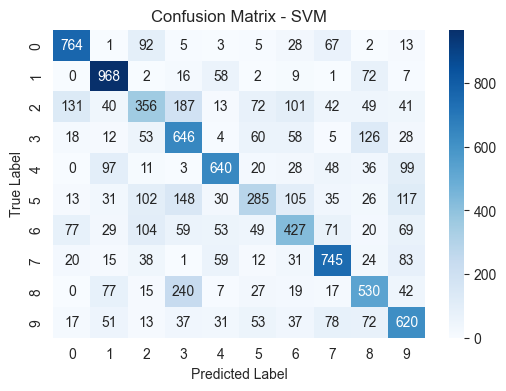

In [110]:
# Train SVM on the processed features
svm_model_zernike = train_svm(train_features_zernike, y_train, test_features_zernike, y_test)

# Predict using the trained model
y_pred_svm_zernike = svm_model_zernike.predict(test_features_zernike)

**PCA:**
A dimensionality reduction technique that transforms correlated features into a set of uncorrelated components (principal components), preserving the most important information while reducing complexity.

*Usefulness:* Reduces the dimensionality of the dataset while preserving the most important variance, speeding up training and improving efficiency.

*Example:* A 28×28 pixel image (784 features) can be reduced to ~50 principal components, capturing most of the digit’s characteristics while reducing complexity.


In [4]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = models.load_preprocess_mnist_data(scale_features=True, flatten_image=True, use_pca=True, pca_variance=0.85)

**KNN - PCA:**


=== KNN ===
Accuracy: 0.9752


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.98,1.00,0.99,1135.00
2,0.98,0.98,0.98,1032.00
3,0.97,0.97,0.97,1010.00
4,0.98,0.98,0.98,982.00
5,0.97,0.97,0.97,892.00
6,0.98,0.99,0.98,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.95,0.97,974.00
9,0.97,0.96,0.97,1009.00


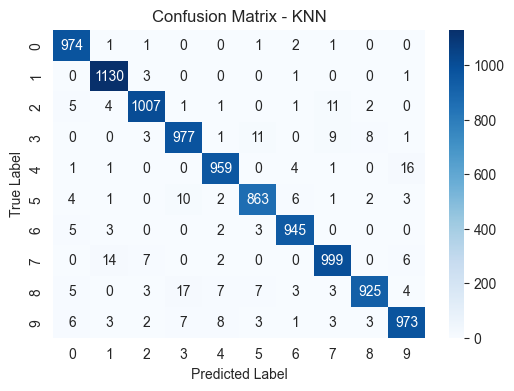

In [5]:
knn = models.train_knn(X_train_pca, y_train_pca, X_test_pca, y_test_pca, k=3)

**Deskew:**
A preprocessing technique that corrects the tilt (skew) of an image, often applied to scanned documents or handwritten text to align content properly for better recognition.

*Usefulness:* Corrects misaligned digits by straightening them, ensuring consistent input for the classifier.

*Example:* A tilted "1" may look like a "/" but after deskewing, it appears more like a proper "1," reducing misclassification.

**Elastic Deformations:**
A transformation that distorts an image by applying small, random displacement fields, commonly used in data augmentation to improve model generalization, especially for handwritten text recognition.

*Usefulness:* Creates realistic variations of handwritten digits by slightly warping the shape, improving model generalization.

*Example:* A "3" written slightly differently due to handwriting variation can still be correctly classified after training with deformed samples.

**Morphological Operations:**
 Image processing techniques (e.g., erosion, dilation, opening, and closing) used to modify the structure of binary or grayscale images, often for noise removal or shape analysis.

*Usefulness:*
 Helps clean up digit images by removing small noise (erosion) or filling gaps in strokes (dilation). This improves the quality of the input for classification.


## Distance Functions ##
On this section we will try to measure the distance between two pictures in varies ways and exmaine how will it effect on the *KNN* classification

KNN normally measure the distance with Euclidean Distance.
we will try:
- Cosine distance
- Euclidean distance
- Manhattan distance


In [111]:

def cosine_distance(vec1, vec2):
    return cosine_distances([vec1], [vec2])[0][0]


def euclidean_distance(vec1, vec2):
    return euclidean_distances([vec1], [vec2])[0][0]


def manhattan_distance(vec1, vec2):
    return manhattan_distances([vec1], [vec2])[0][0]


def image_distortion_model_distance(img1, img2):
    """
    Custom IDM distance function.
    img1, img2: Flattened image vectors.
    Returns: IDM-based distance.
    """
    # Reshape to 2D if needed (assuming square images)
    size = int(np.sqrt(len(img1)))  # Assuming square images
    img1 = img1.reshape((size, size))
    img2 = img2.reshape((size, size))

    # IDM Distance Computation (simplified version)
    dist = 0
    for i in range(size):
        for j in range(size):
            local_diffs = [abs(img1[i, j] - img2[i + di, j + dj])
                           for di in range(-1, 2) for dj in range(-1, 2)
                           if 0 <= i + di < size and 0 <= j + dj < size]
            dist += min(local_diffs) if local_diffs else abs(img1[i, j] - img2[i, j])

    return dist

**Cosine Distance:**
Measures the angle between two vectors, focusing on direction rather than magnitude.
Useful when brightness variations affect pixel intensity but not digit shape.


=== KNN With Cosine Distance ===
Accuracy: 0.9733


,precision,recall,f1-score,support
0,0.96,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.97,0.97,1010.00
4,0.98,0.96,0.97,982.00
5,0.97,0.96,0.97,892.00
6,0.98,0.99,0.98,958.00
7,0.98,0.97,0.97,1028.00
8,0.98,0.96,0.97,974.00
9,0.95,0.96,0.96,1009.00


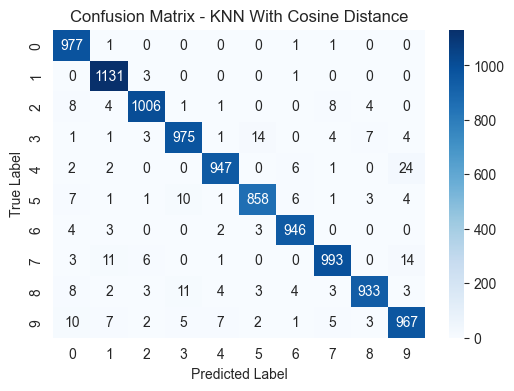

In [112]:
knn_cosine = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_cosine.fit(X_train, y_train)
y_pred_cosine = knn_cosine.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Cosine Distance", y_test, y_pred_cosine)

**Euclidean Distance:**
Measures the straight-line distance between two points in a high-dimensional space.
Commonly used for KNN classification of MNIST digits. (default of KNN)


=== KNN With Euclidean Distance ===
Accuracy: 0.9705


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.96,1.00,0.98,1135.00
2,0.98,0.97,0.97,1032.00
3,0.96,0.97,0.96,1010.00
4,0.98,0.97,0.97,982.00
5,0.97,0.96,0.96,892.00
6,0.98,0.99,0.98,958.00
7,0.96,0.96,0.96,1028.00
8,0.99,0.94,0.96,974.00
9,0.96,0.96,0.96,1009.00


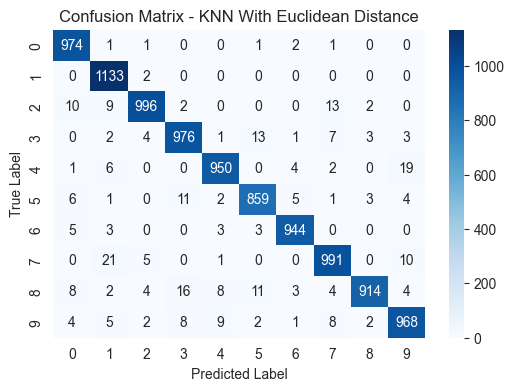

In [113]:
knn_euclidean = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_euclidean.fit(X_train, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Euclidean Distance", y_test, y_pred_euclidean)

**Manhattan Distance:**
Measures distance by summing absolute differences between coordinates.
More robust to outliers than Euclidean distance.


=== KNN With Manhattan Distance ===
Accuracy: 0.9633


,precision,recall,f1-score,support
0,0.96,0.99,0.98,980.00
1,0.94,1.00,0.97,1135.00
2,0.98,0.95,0.97,1032.00
3,0.96,0.96,0.96,1010.00
4,0.97,0.95,0.96,982.00
5,0.96,0.96,0.96,892.00
6,0.98,0.98,0.98,958.00
7,0.95,0.96,0.95,1028.00
8,0.99,0.92,0.95,974.00
9,0.95,0.95,0.95,1009.00


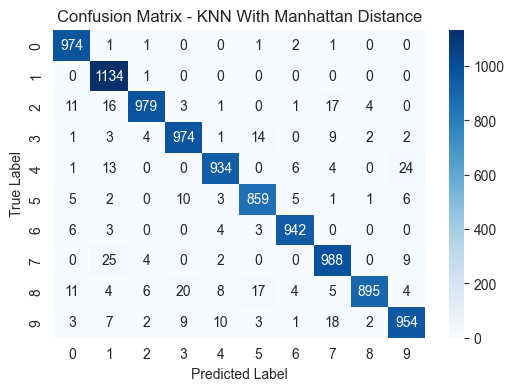

In [114]:
knn_manhattan = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn_manhattan.fit(X_train, y_train)
y_pred_manhattan = knn_manhattan.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Manhattan Distance", y_test, y_pred_manhattan)